# **Modelling and Evaluation**

## Objectives

* Answer business requirement 1:
    * The client aims to visually differentiate lesions. The model should be capable of reaching an accuracy of at least 70%.
<br><br>

* Answer business requirement 2:
    - The model should provide a confidence level for each prediction.
<br><br>

* Answer business requirement 3:
    - If a skin lesion is predicted as malignant with high confidence, the system should recommend immediate medical consultation.
<br><br>

* Answer business requirement 5:
    - The AI model's insights should assist healthcare professionals in making informed decisions about the treatment process.
<br><br>

* Answer business requirement 6:
    - The model's performance will be evaluated using balanced performance metrics such as F1 Score.
<br><br>
## Inputs

* inputs/skin_cancer_dataset/sorted_images/train
* inputs/skin_cancer_dataset/sorted_images/test
* inputs/skin_cancer_dataset/sorted_images/validation
* image shape embeddings

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

## Additional Comments

* First version.

---

---

# Import regular packages

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-06-15 12:53:21.387957: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


---

# Change working directory

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/danielhamilton/CI/project5/AI-DermDiagnosis/jupyter_notebooks'

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [5]:
current_dir = os.getcwd()
current_dir

'/Users/danielhamilton/CI/project5/AI-DermDiagnosis'

---

## Set input directories

Set train, validation and test paths.

In [6]:
my_data_dir = 'inputs/skin_cancer_dataset/sorted_images'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [7]:
version = 'modelling_evaluation_v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

## Set label names

In [10]:
# Set the labels
train_labels = os.listdir(train_path)
print('Label for train set the images are', train_labels, 'there are', len(train_labels) )
test_labels = os.listdir(test_path)
print('Label for test set the images are', test_labels, 'there are', len(test_labels) )
val_labels = os.listdir(val_path)
print('Label for val set the images are', val_labels, 'there are', len(val_labels) )

Label for train set the images are ['akiec', 'df', 'bkl', 'vasc', 'nv', 'bcc', 'mel'] there are 7
Label for test set the images are ['akiec', 'df', 'bkl', 'vasc', 'nv', 'bcc', 'mel'] there are 7
Label for val set the images are ['akiec', 'df', 'bkl', 'vasc', 'nv', 'bcc', 'mel'] there are 7


## Set image shape

In [11]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(450, 600, 3)

---

# Number of images in train, test and validation data

* train - akiec: 228 images
* train - df: 80 images
* train - bkl: 769 images
* train - vasc: 99 images
* train - nv: 4693 images
* train - bcc: 359 images
* train - mel: 779 images
* validation - akiec: 32 images
* validation - df: 11 images
* validation - bkl: 109 images
* validation - vasc: 14 images
* validation - nv: 670 images
* validation - bcc: 51 images
* validation - mel: 111 images
* test - akiec: 67 images
* test - df: 24 images
* test - bkl: 221 images
* test - vasc: 29 images
* test - nv: 1342 images
* test - bcc: 104 images
* test - mel: 223 images




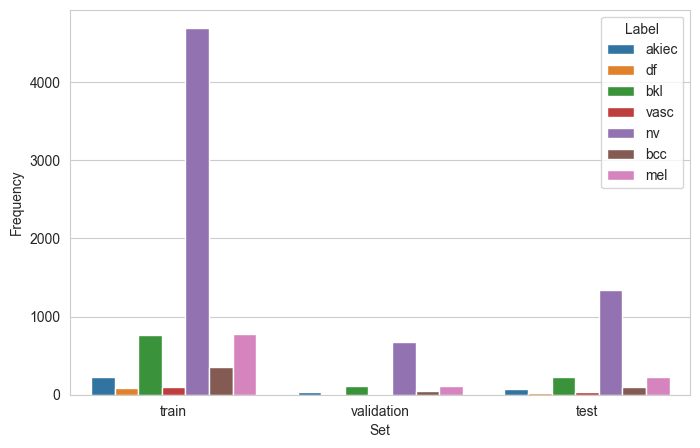

In [13]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in train_labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

## Build training set

In [14]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Get the list of all classes (subdirectories in your train directory)
classes = os.listdir(train_path)

# Initialize the list that will contain all images
X_train = []

# Initialize the list that will contain all labels
y_train = []

# For each class (subdirectory) in your train directory
for class_name in classes:
    # Get the list of all images in this subdirectory
    images = os.listdir(os.path.join(train_path, class_name))
    
    # For each image
    for image_name in images:
        # Construct the full path to the image
        image_path = os.path.join(train_path, class_name, image_name)
        
        # Read the image and resize it to some fixed size (e.g., 150x150)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (150, 150))
        
        # Add this image to the list of all images
        X_train.append(image)
        
        # Add the label (class name) of this image to the list of all labels
        y_train.append(class_name)

# Convert the list of images into a numpy array
X_train = np.array(X_train)

# # Convert the labels into integers
label_encoder = LabelEncoder()
y_train_encode = label_encoder.fit_transform(y_train)

## Initialize ImageDataGenerator

In [16]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

## Augment training image dataset

In [17]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

print(image_shape[:2])
train_set.class_indices

Found 7007 images belonging to 7 classes.
(450, 600)


{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

## Augment validation image dataset

In [18]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 998 images belonging to 7 classes.


{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

## Augment test image dataset

In [19]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 2010 images belonging to 7 classes.


{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

## Plot augmented training image

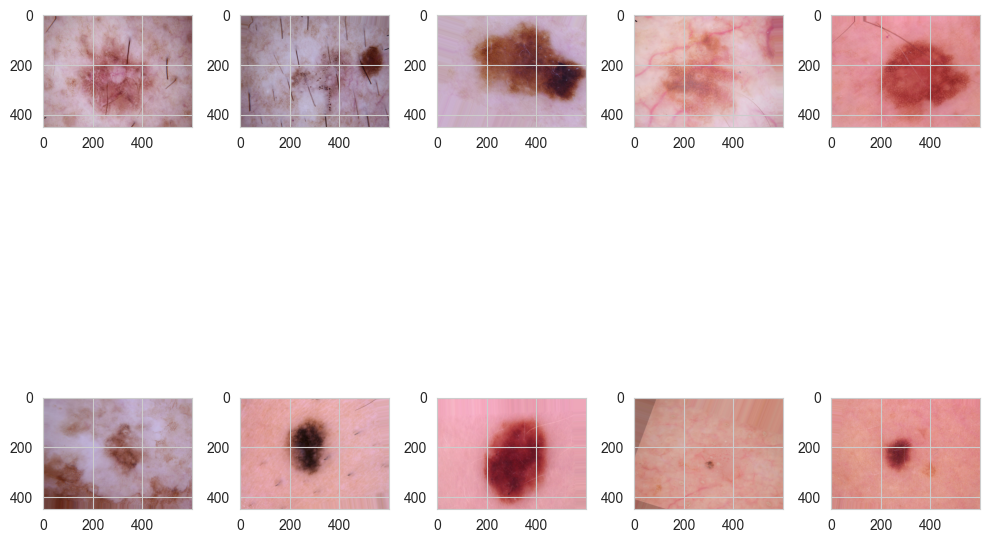

In [20]:
f, ax = plt.subplots(2, 5)
f.set_size_inches(10, 10)

k = 0
for i in range(2):
    for j in range(5):
        img, train_label = train_set.next()
        ax[i, j].imshow(img[0])
        k = k + 1

plt.tight_layout()
plt.show()

## Plot augmented validation images

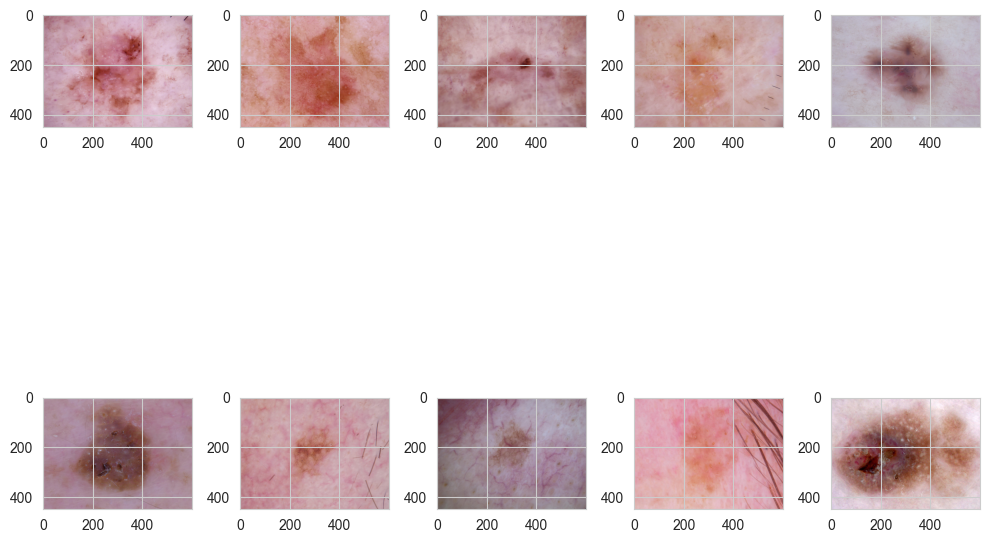

In [21]:
f, ax = plt.subplots(2, 5)
f.set_size_inches(10, 10)

k = 0
for i in range(2):
    for j in range(5):
        img, val_label = validation_set.next()
        ax[i, j].imshow(img[0])
        k = k + 1

plt.tight_layout()
plt.show()

## Plot augmented test images

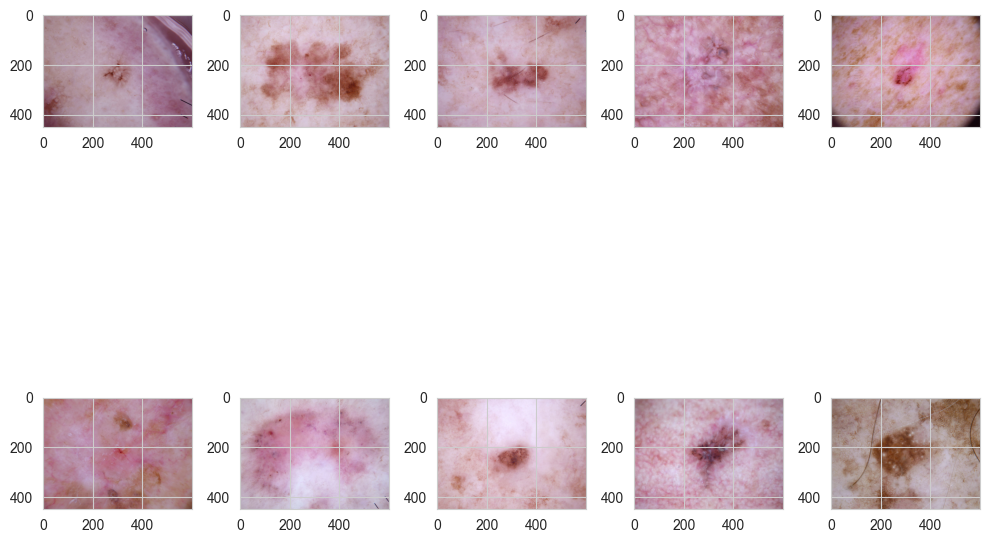

In [22]:
f, ax = plt.subplots(2, 5)
f.set_size_inches(10, 10)

k = 0
for i in range(2):
    for j in range(5):
        img, test_label = test_set.next()
        ax[i, j].imshow(img[0])
        k = k + 1

plt.tight_layout()
plt.show()

## Save class_indices

In [23]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/modelling_evaluation_v1/class_indices.pkl']

---

# Model creation

---

## ML model

### Import model packages

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

### Model

In [27]:
def create_tf_model(num_classes, input_shape=(450, 600, 3)):
    # Initialize the Sequential model
    model = Sequential()

    # Adding Convolutional Layers
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flattening the output of the convolutional layers
    model.add(Flatten())

    # Adding Dense Layers
    model.add(Dense(512, activation='relu'))
    
     # Flattening the output of the convolutional layers
    model.add(Flatten())

    # Adding Dropout for regularization
    model.add(Dropout(0.5))

    # Output Layer (Softmax for multi-class classification)
    model.add(Dense(num_classes, activation='softmax'))

    # Compiling the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Return the compiled model
    return model

### Model Summary

In [28]:
create_tf_model(num_classes=7).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 448, 598, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 224, 299, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 297, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 148, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 146, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 73, 128)     

### Early Stopping

In [29]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

### Fit model for model training

In [30]:
from tensorflow.keras.utils import to_categorical

model = create_tf_model(num_classes=7)

model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25


2023-06-15 13:31:53.043777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


350/350 [==============================] - ETA: 0s - loss: 1.1896 - accuracy: 0.6592

2023-06-15 13:55:03.278975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


350/350 [==============================] - 1418s 4s/step - loss: 1.1896 - accuracy: 0.6592 - val_loss: 0.9675 - val_accuracy: 0.6693
Epoch 2/25
350/350 [==============================] - 1410s 4s/step - loss: 0.9491 - accuracy: 0.6685 - val_loss: 0.8813 - val_accuracy: 0.6703
Epoch 3/25
350/350 [==============================] - 1404s 4s/step - loss: 0.8985 - accuracy: 0.6727 - val_loss: 0.8400 - val_accuracy: 0.6794
Epoch 4/25
350/350 [==============================] - 1422s 4s/step - loss: 0.8920 - accuracy: 0.6677 - val_loss: 0.8661 - val_accuracy: 0.6764
Epoch 5/25
350/350 [==============================] - 1421s 4s/step - loss: 0.8790 - accuracy: 0.6745 - val_loss: 0.8506 - val_accuracy: 0.6804
Epoch 6/25
350/350 [==============================] - 1416s 4s/step - loss: 0.8511 - accuracy: 0.6790 - val_loss: 0.8395 - val_accuracy: 0.6814
Epoch 7/25
350/350 [==============================] - 1310s 4s/step - loss: 0.8542 - accuracy: 0.6760 - val_loss: 0.8713 - val_accuracy: 0.6834
Epo

## Save model

In [31]:
model.save('outputs/modelling_evaluation_v1/lesion_classifier_model.h5')

---

## Model Performance

---

## Model learning curve

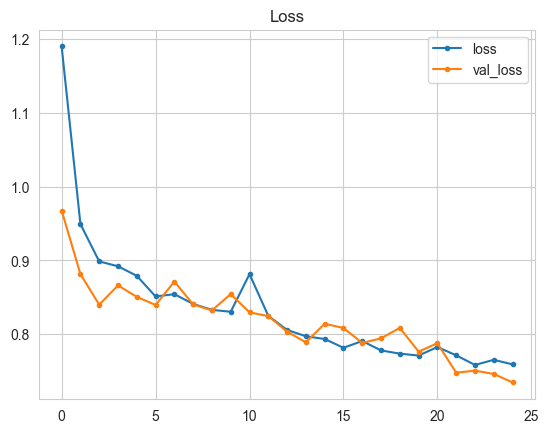

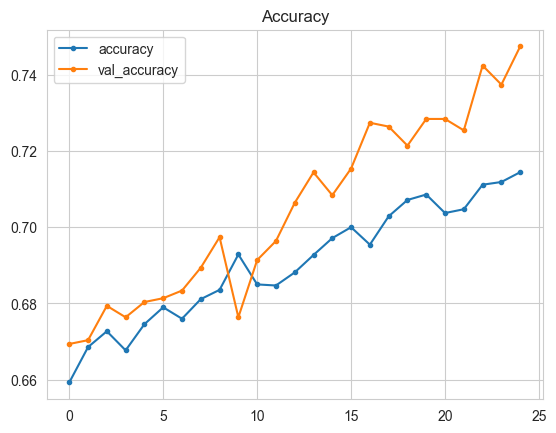

In [32]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

### Load Model

In [35]:
from keras.models import load_model
model = load_model(f"{file_path}/lesion_classifier_model.h5")

### Evaluate Model

In [36]:
evaluation = model.evaluate(test_set)

2023-06-16 08:27:20.312258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


101/101 [==============================] - 61s 599ms/step - loss: 0.7320 - accuracy: 0.7184


### Save evaluation pickle

In [37]:
joblib.dump(value=evaluation,
            filename=f"{file_path}/evaluation.pkl")

['outputs/modelling_evaluation_v1/evaluation.pkl']

## Predict on new data

1/1 [==============================] - 0s 124ms/step


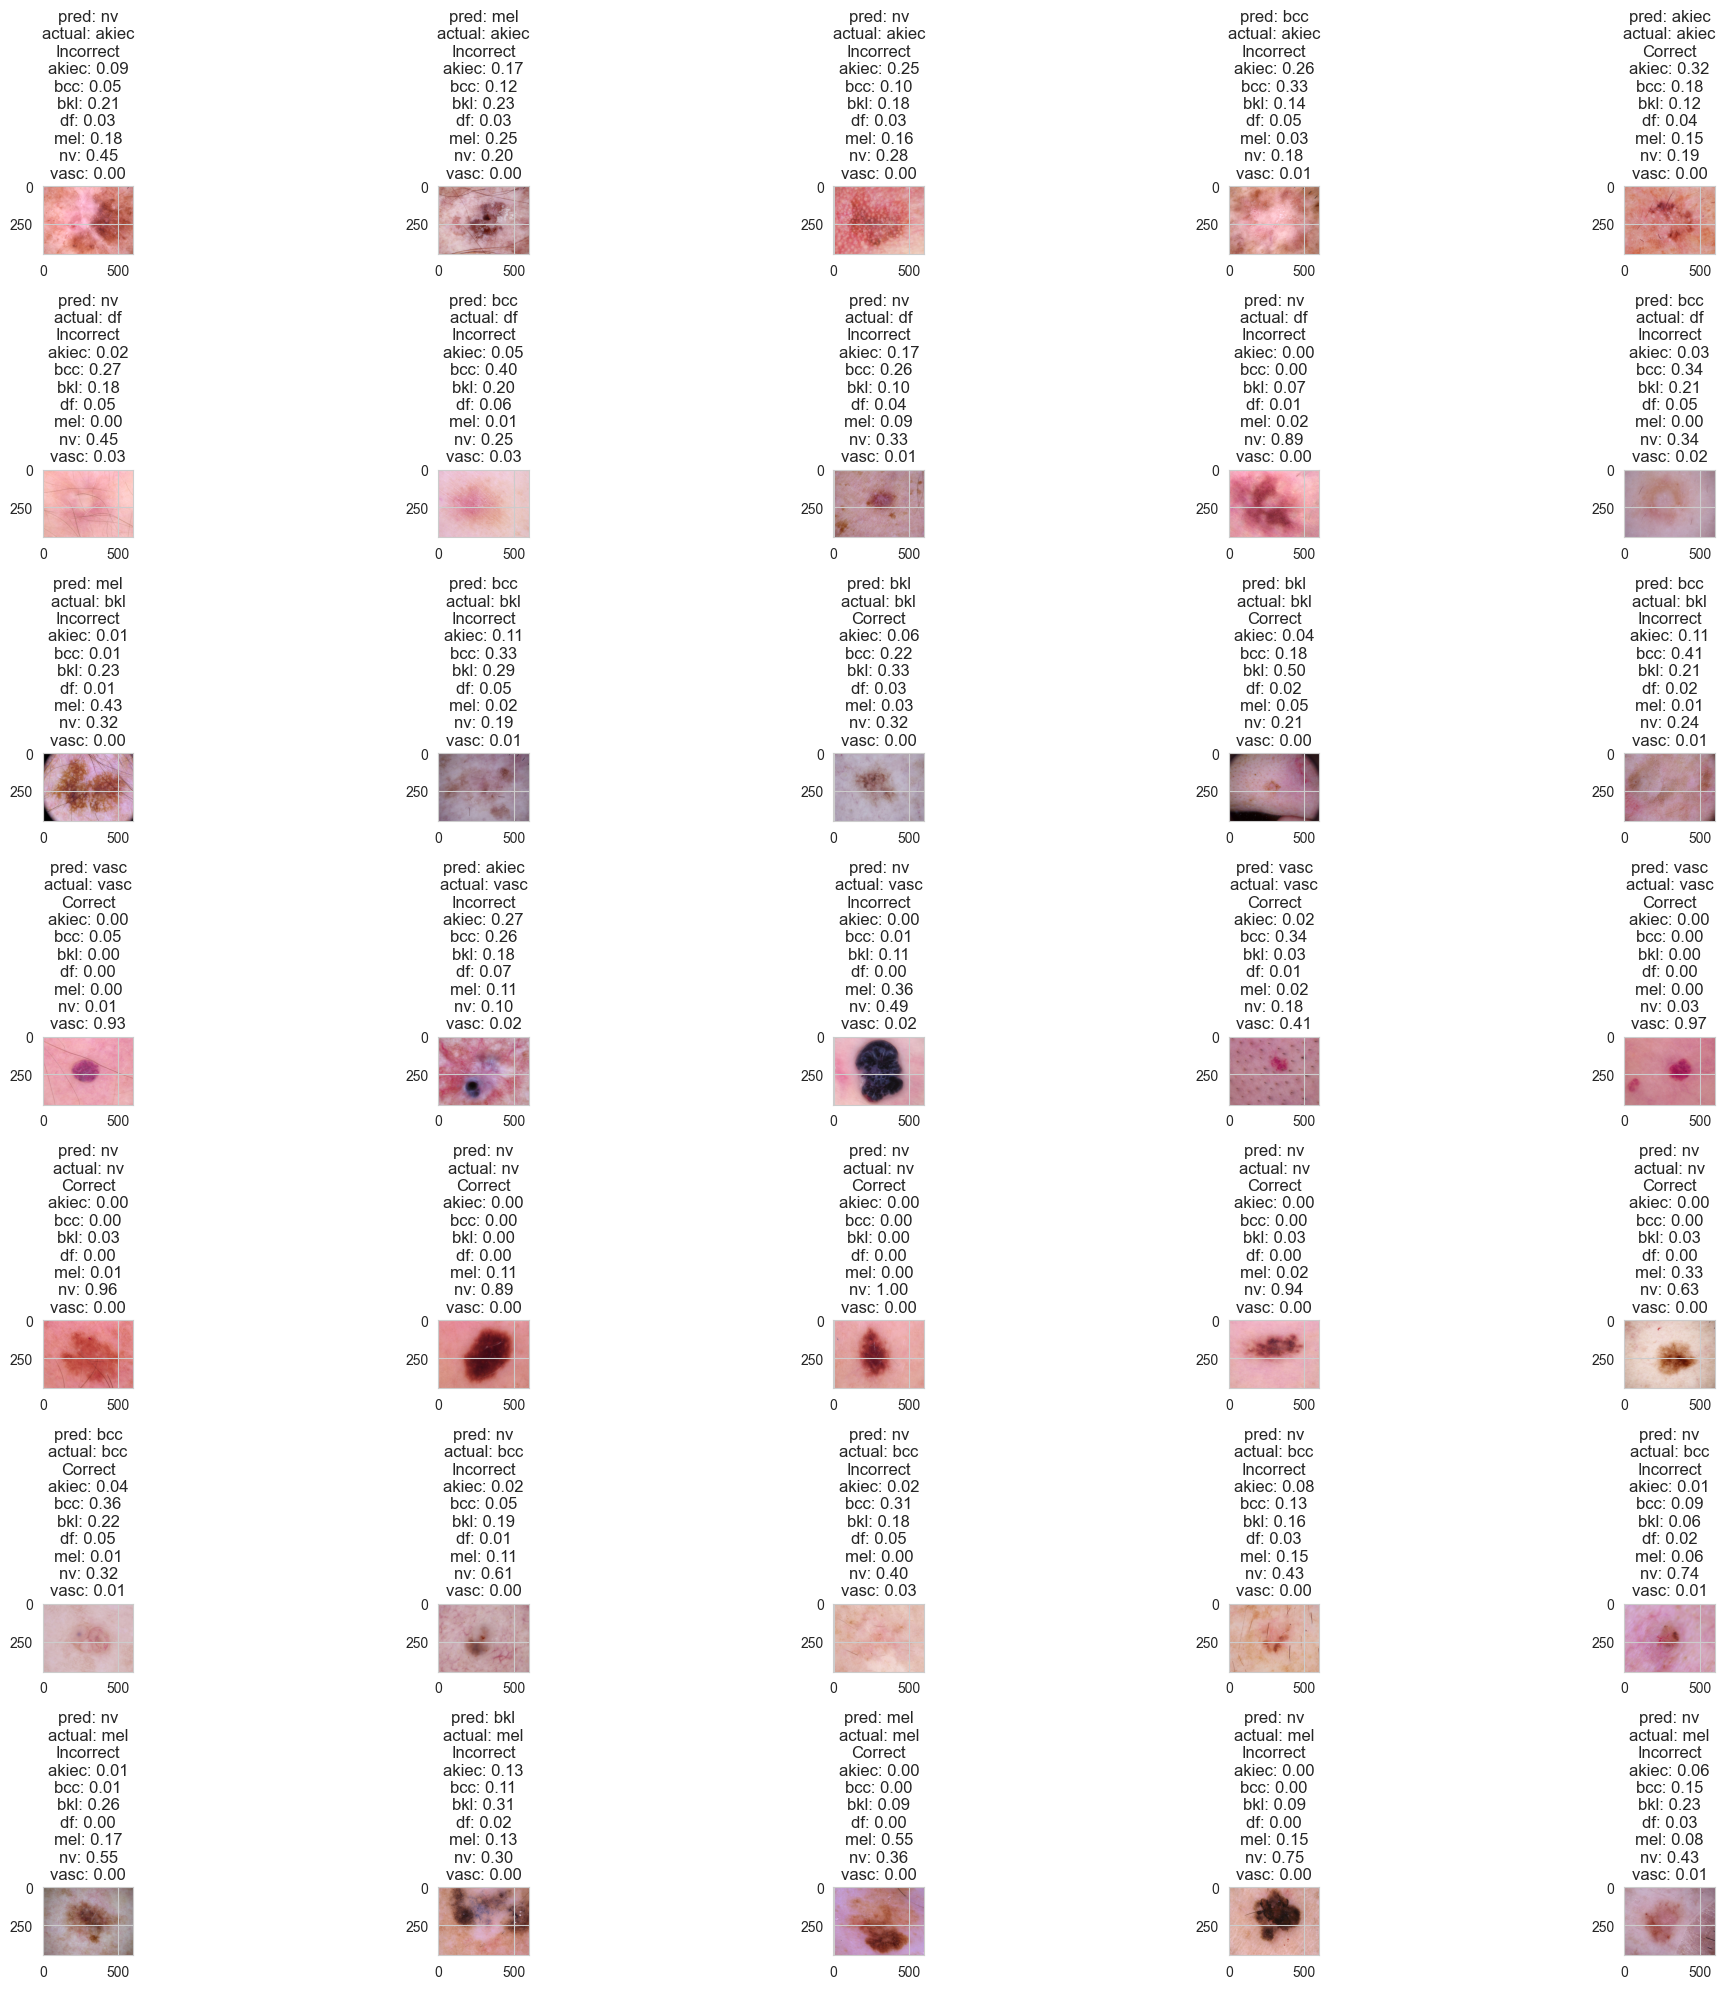

In [42]:
import random
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

f, ax = plt.subplots(7, 5)  # 7 rows for 7 classes, 5 columns for 5 images each
f.set_size_inches(20, 20)  # adjust size for better display

# counters for each class
correct_counts = {label: 0 for label in train_labels}
total_counts = {label: 0 for label in train_labels}

# assuming train_labels contains the names of the 7 classes
for row, label in enumerate(train_labels):
    image_files = os.listdir(test_path + '/' + label)

    # Select 5 random indices
    random_indices = random.sample(range(len(image_files)), 5)

    for col, idx in enumerate(random_indices):
        pil_image = image.load_img(test_path + '/' + label + '/' + image_files[idx], target_size=image_shape, color_mode='rgb')
        
        my_image = image.img_to_array(pil_image)
        my_image = np.expand_dims(my_image, axis=0)/255
        
        pred_proba = model.predict(my_image)[0]
        
        target_map = {v: k for k, v in train_set.class_indices.items()}
        pred_class_index = np.argmax(pred_proba)  # find the index with max probability
        pred_class = target_map[pred_class_index]
        
        # Text for probabilities
        probabilities_text = '\n'.join([f"{target_map[i]}: {p:.2f}" for i, p in enumerate(pred_proba)])

        # Check if prediction is correct
        is_correct = pred_class == label
        if is_correct:
            correct_counts[label] += 1
        total_counts[label] += 1
        
        # Check if prediction is correct
        is_correct = 'Correct' if pred_class == label else 'Incorrect'
        
        # Here I include the predicted class (pred_class), the actual class (label), and the probabilities
        ax[row, col].imshow(pil_image)
        ax[row, col].set_title(f"pred: {pred_class}\nactual: {label}\n{is_correct}\n{probabilities_text}")

plt.tight_layout()
plt.show()


## Predict on new data summary

In [47]:
# Calculate and print accuracy for each class
total_correct = 0
for label in train_labels:
    total_correct = total_correct + correct_counts[label] 
    accuracy = (correct_counts[label] / total_counts[label]) * 100 if total_counts[label] > 0 else 0
    print(f"Accuracy for class {label}: {accuracy:.2f}% ({correct_counts[label]}/{total_counts[label]})")
    
total_accuracy = (total_correct / 35) * 100 if total_correct > 0 else 0
print()
print(f"Total correct: {total_correct}")
print(f"Accuracy total: {total_accuracy:.2f}% ({total_correct}/35)")

Accuracy for class akiec: 20.00% (1/5)
Accuracy for class df: 0.00% (0/5)
Accuracy for class bkl: 40.00% (2/5)
Accuracy for class vasc: 60.00% (3/5)
Accuracy for class nv: 100.00% (5/5)
Accuracy for class bcc: 20.00% (1/5)
Accuracy for class mel: 20.00% (1/5)

Total correct: 13
Accuracy total: 37.14% (13/35)


---

---

NOTE

* The results suggest that the model is quite effective in identifying the 'nv' class but struggles considerably with the other classes, particularly 'df'. The performance disparity across different classes indicates that the model might benefit from further training or refinement, such as data augmentation, class balancing, hyperparameter tuning, or employing a different model architecture.

---